<a href="https://colab.research.google.com/github/Nuthan03/Food-Vision/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Food Vision

## Check Gpu

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we are using our own hardware, our on GPU needs a score of 7.9+ (see here :[Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0836c292-b9a8-4121-59bb-fe6896c17998)


## Get helper functions

In past we have created a bunch of helper functions to do small tasks required for our notebooks.
Rather than rewrite all of these, we can import a script and load them in from there.

In [ ]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-12-10 07:22:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-10 07:22:22 (80.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import serise of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves , compare_historys

## Use TensorFlow Datasets to Download Data


In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets

True


In [ ]:
# Load in the data (takes 5-6 mins in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete1OVISK/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete1OVISK/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we should find:
* Class names
* The shape of our input data (image tensors)
* The datatypes of our input data
* What the labels look like ?
* Do the labels match up with the class names?


In [ ]:
# Take oen sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatypes: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatypes: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 49
  Class name (str form): grilled_cheese_sandwich
  


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

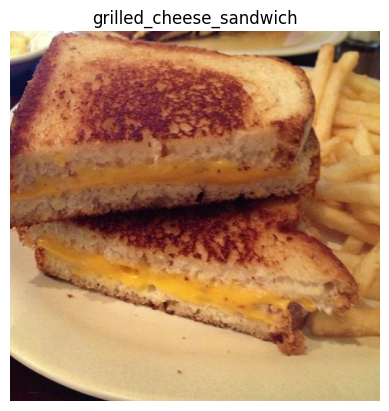

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # Reshape to img_shape
  # image = image/255. #(not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # Return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[238.7704   217.41327  155.4847  ]
  [242.83673  222.83673  162.55101 ]
  [240.85713  220.20918  164.2143  ]
  ...
  [131.28564  118.28565   75.7806  ]
  [123.88257  109.81113   75.09689 ]
  [106.698746  90.698746  66.4131  ]]

 [[232.16325  212.09183  141.37755 ]
  [238.86224  219.86224  151.07654 ]
  [239.94388  221.08673  155.87245 ]
  ...
  [127.49998  112.49998   71.07145 ]
  [122.63767  106.56623   72.852   ]
  [105.83142   88.47424   63.1886  ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepared datasets

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE).cache()


In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks

We are going to create a couple of callabacks to help us while our model trains:
* Tensorboard callbacks to log training results.
* ModelCheckpoint callbacks to save our model's progress after extraction

In [ ]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build Feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescalling built-in but if your model doesnt you could have a layer like below
# x = preprocessing.Rescaling(1./255.)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fit the feature extraction model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_class_feature_extract = model.fit(train_data,
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15 * len(test_data)),
                                                   callbacks=[create_tensorboard_callback("training_logs",
                                                                                          "efficientnetb0_101_classes_all_data_feature_extract"),
                                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231210-073248
Epoch 1/3
2368/2368 [==============================] - 237s 89ms/step - loss: 1.7176 - accuracy: 0.5815 - val_loss: 1.1268 - val_accuracy: 0.6968
Epoch 2/3
2368/2368 [==============================] - 207s 85ms/step - loss: 1.1996 - accuracy: 0.6893 - val_loss: 1.0280 - val_accuracy: 0.7169
Epoch 3/3
2368/2368 [==============================] - 196s 81ms/step - loss: 1.0540 - accuracy: 0.7232 - val_loss: 0.9887 - val_accuracy: 0.7246
